# Hot 100 Song Predictor
By: Harrison Ly and Raymon Shi



Though there are many people that listen to music, no two people have the same music taste. And yet, artists can unite a few to a million listeners with their songs. Given wide range of genres, languages, and fans, we are interested in finding out what makes a song so popular. More specifically, we wish to explore whether certain qualities of a song can affect whether it makes the Billboard's Hot 100 list or not. Through pulling songs from Billboard, lyrics from Lyrical Genius, and song features from Spotify, we intend to predict if a song will make the Hot 100 list.

## Setting Up
We start by importing all of the neccesary modules, defining our access tokens annd creditials to for the Lyrical Genius and Spotify APIs. We also mount our Google Drive folder to store our data as json files.

In [ ]:
!pip install lyricsgenius
!pip install billboard.py
!pip install nltk==3.4
!pip install pandas spotipy tqdm
!pip install --upgrade requests

In [ ]:
# i/o imports
from google.colab import drive
import json

import requests
from requests import ReadTimeout

# API imports
import billboard as bb
from lyricsgenius import Genius as lg 
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth

# nltk imports
import nltk
from nltk import ngrams
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download([
    "names",
     "stopwords",
     "state_union",
     "twitter_samples",
     "movie_reviews",
     "averaged_perceptron_tagger",
     "vader_lexicon",
     "punkt",
 ])
sia = SentimentIntensityAnalyzer()

# pandas and graphs imports
import pandas as pd
import matplotlib.pyplot as plt

# model imports
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package state_union to /root/nltk_data...
[nltk_data]   Package state_union is already up-to-date!
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package 

In [ ]:
# Google Drive Mount Setup
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# LyricsGenius API Setup
MY_CLIENT_ACCESS_TOKEN = "vBDGzYWAqYXmgDgmIi7Lj2pmrv05CLvMVGDJ92hNwkyGjMhX7gjUEPsOa9blpEzF"
genius = lg(MY_CLIENT_ACCESS_TOKEN, timeout=60, remove_section_headers=True)

In [ ]:
# Spotipy API Client Setup
spotify_client_id = 'a55af1881017467b9adcbe1e9d8a01bf'
spotify_client_secret_id = 'f365a202ea9341e1952b312d9378fa7e'

spotify_credentials_manager = SpotifyClientCredentials(client_id=spotify_client_id, client_secret=spotify_client_secret_id)
spotify_client = spotipy.Spotify(client_credentials_manager=spotify_credentials_manager, requests_timeout=10, retries=10)

# Extracting Data From APIs
We used the Billboard API, Spotipy API, and Lyrical Genius API to extract song information. Once we extracted the necessary data, we stored them in json files in order to save the time of extracting the data again.

For the Billboard API, we used an external application that fetches the Billboard Hot 100 songs at a given date and stores them in a Chart object. For each year, we extracted the aritst, song title, song rank, and chart date from each Chart and stored them in a dictionary. Finally, we appended the dictionaries of every song into a single list.

In [ ]:
chart_list = []
for year in range(1990, 2020):
    base_date_format = str(year) + "-12-25"

    chart = bb.ChartData(name= "hot-100", date= base_date_format, fetch=True, timeout=60)
    chart_list.append(chart)

In [ ]:
song_dictionary = dict()
song_list = []
for chart in chart_list:
    for song in chart:
        song_dict = {"title": song.title,
         "artist": song.artist,
         "rank": song.rank,
         "date": chart.date
        }
        song_list.append(song_dict)

In [ ]:
# here is what a song dictionary looks like
song_list[0]

[{'title': 'Independent Women Part I', 'artist': "Destiny's Child", 'rank': 1, 'date': '2000-12-30'}, {'title': 'He Loves U Not', 'artist': 'Dream', 'rank': 2, 'date': '2000-12-30'}, {'title': "It Wasn't Me", 'artist': 'Shaggy Feat. Ricardo "RikRok" Ducent', 'rank': 3, 'date': '2000-12-30'}, {'title': 'Case Of The Ex (Whatcha Gonna Do)', 'artist': 'Mya', 'rank': 4, 'date': '2000-12-30'}, {'title': 'With Arms Wide Open', 'artist': 'Creed', 'rank': 5, 'date': '2000-12-30'}, {'title': 'Ms. Jackson', 'artist': 'OutKast', 'rank': 6, 'date': '2000-12-30'}, {'title': 'The Way You Love Me', 'artist': 'Faith Hill', 'rank': 7, 'date': '2000-12-30'}, {'title': "If You're Gone", 'artist': 'matchbox twenty', 'rank': 8, 'date': '2000-12-30'}, {'title': 'Kryptonite', 'artist': '3 Doors Down', 'rank': 9, 'date': '2000-12-30'}, {'title': 'Dance With Me', 'artist': 'Debelah Morgan', 'rank': 10, 'date': '2000-12-30'}, {'title': 'I Just Wanna Love U (Give It 2 Me)', 'artist': 'JAY-Z', 'rank': 11, 'date': 

Using the song list, we used the Lyrical Genius API to look up the lyrics for each song using the song title and artist as our search parameters. We then appended those lyrics to the metadata dictionaries of each song and stored them into a new list for songs with lyrics. Unfrotunately, Lyrical Genius did not have lyrics for some song and artist combinations so we decided to store those songs in a separate list.

In [ ]:
%%script echo skipping
all_songs_with_lyrics = []
missed_songs = []
counter = 0

# loop through all 1,000 song dictionaires
for song_data in song_list:
    counter = counter + 1
    print(counter, "HELLO COUNT")
    # attempt to look for the song
    try:
        lg_song = genius.search_song(title=song_data['title'], artist=song_data['artist'])
    # otherwise, add the song to the alternative list and go to next iteration
    except Exception:
        error_dict = {
            "title": song_dict["title"],
            "artist": song_dict["artist"]
        }
        missed_songs.append(error_dict)
        continue
    # if there is a sucessful API call, then add create the song dictionary and add it to the list of song dictioanries
    if lg_song:
        song_dict = {
            "title": song_data["title"],
            "artist": song_data["artist"],
            "date": song_data["date"],
            "rank": song_data["rank"],
            "lyrics": lg_song.lyrics
        }
        all_songs_with_lyrics.append(song_dict)

Streaming output truncated to the last 5000 lines.
Searching for "Bright Lights" by matchbox twenty...
Done.
1332 HELLO COUNT
Searching for "Why Can't I?" by Liz Phair...
Done.
1333 HELLO COUNT
Searching for "Gigolo" by Nick Cannon Featuring R. Kelly...
Done.
1334 HELLO COUNT
Searching for "Salt Shaker" by Ying Yang Twins Featuring Lil Jon & The East Side Boyz...
Done.
1335 HELLO COUNT
Searching for "Right Thurr" by Chingy...
Done.
1336 HELLO COUNT
Searching for "The Voice Within" by Christina Aguilera...
Done.
1337 HELLO COUNT
Searching for "Harder To Breathe" by Maroon 5...
Done.
1338 HELLO COUNT
Searching for "(There's Gotta Be) More To Life" by Stacie Orrico...
Done.
1339 HELLO COUNT
Searching for "Through The Wire" by Kanye West...
Done.
1340 HELLO COUNT
Searching for "Shake Ya Tailfeather" by Nelly, P. Diddy & Murphy Lee...
Done.
1341 HELLO COUNT
Searching for "I Love This Bar" by Toby Keith...
Done.
1342 HELLO COUNT
Searching for "You Can't Take The Honky Tonk Out Of The Girl" b

In [ ]:
# check the length of the songs list and the error list
print(len(all_songs_with_lyrics))
print(len(missed_songs))

2904
13


We then wrote the resulting list of song dictionaries as a JSON file. This way, we won't have to reload and requiery the LyricsGenius API every time we want to run our notebook. We saved the JSON file on Google Drive, in a shared folder called "Song JSON Files".

In [ ]:
# Please use this link to get access to our shared Google Drive folder
# https://drive.google.com/drive/folders/1Z7qakIk7trxZ1cw6el_Y1DloGrRcv6zE?usp=sharing
# Once you have it, please move the folder into your drive.
# Thanks!
%%script echo skipping
# write the results to JSON
jsonString = json.dumps(all_songs_with_lyrics)
jsonFile = open("hot100songs_with_lyrics.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

Next, we looked through a large dataset of 1,000,000 Spotify playlists and we collected 10,000 songs from the dataset. We proceeded to do a similar process for what we did with the Billboard Hot 100 songs. We looked up each of these songs with the LyricsGenius API and created a list of song dictionaries for all of the songs from the Spotify playlist dataset. Once again, if the LyricsGenius returned an error, we added that song and artist pair to an alternative list. Afterward, we wrote the results out to a JSON file so we can quickly and easily access the results in the future.

In [ ]:
# file that contains 1,000 spotify playlist
first_thousand_playlist = '/content/drive/MyDrive/Song JSON Files/mpd.slice.0-999.json'

# parse the JSON file
with open(first_thousand_playlist) as spotify_playlist_1000:
    data = json.load(spotify_playlist_1000)

spotify_song_set = set()
breaker = False

# accumulate 10,000 songs from these random playlists
for playlist in data['playlists']:
    if (breaker):
        break
    for track in playlist['tracks']:
        if len(spotify_song_set) < 10000:
            spotify_song_set.add((track['track_name'], track['artist_name']))
        else:
            breaker = True
            break

In [ ]:
%%script echo skipping
song_counter = 0
missed_songs_spotify = []
all_songs_with_lyrics_spotify = []

# loop through all 10,000 song dictionaires
for song in spotify_song_set:
    song_counter = song_counter + 1
    print(song_counter, "HELLO COUNT")
    # attempt to look for the song
    try:
        lg_song_spotify = genius.search_song(title=song[0], artist=song[1])
    # otherwise, add the song to the alternative list and go to next iteration
    except Exception:
        error_dict_spotify = {
            "title": song[0],
            "artist": song[1]
        }
        missed_songs_spotify.append(error_dict_spotify)
        continue
    # if there is a sucessful API call, then add create the song dictionary and add it to the list of song dictioanries
    if lg_song_spotify:
        song_dict_spotify = {
            "title": song[0],
            "artist": song[1],
            "lyrics": lg_song_spotify.lyrics
        }
        all_songs_with_lyrics_spotify.append(song_dict_spotify)

skipping


In [ ]:
%%script echo skipping
# write the results to JSON
jsonStringSpotify = json.dumps(all_songs_with_lyrics_spotify)
jsonFile = open("songs_with_lyrics.json", "w")
jsonFile.write(jsonStringSpotify)
jsonFile.close()

# Looking at N-Grams and Sentimental Analysis for the Billboard Hot 100 Songs Corpus

Our next step is to load in our prescrapped data from the JSON files, perform some text cleaning and text analysis on the song lyrics, and perform sentiment analysis on the song lyrics. In order to do this, we use the NLTK library, which has tools such as a list of stopwords, a tokenizer function, and a n-gram function.

In [ ]:
hot100_json = '/content/drive/MyDrive/Song JSON Files/hot100songs_with_lyrics.json'
spotify_json = '/content/drive/MyDrive/Song JSON Files/songs_with_lyrics.json'

In [ ]:
with open(hot100_json) as json_file:
    hot100_data = json.load(json_file)

with open(spotify_json) as json_file_spotify:
    spotify_data = json.load(json_file_spotify)

In [ ]:
# this is what hot100_data looks like
hot100_data[0]

{'artist': 'Stevie B',
 'date': '1990-12-29',
 'lyrics': "I got your letter from the postman just the other day\nSo I decided to write you this song\nAnd just to let you know exactly the way I feel\nAnd let you know my love's for real\nBecause I love you\nAnd I'll do anything\nI'll give you my heart, my everything\nBecause I love you\nI'll be right by your side\nTo be your light, to be your guide\nIf you should feel that I don't really care\nAnd that you're starting to lose ground\nJust let me reassure you that you can count on me\nAnd that I'll always be around\nBecause I love you\nMy heart's an open door\nGirl, won't you please come on in\nBecause I love you\nI'll be right by your side\nTo be your light, to be your guide\nIf you should feel that I don't really care\nAnd that you're starting to lose your ground\nJust let me reassure you that you can count on me\nAnd that I will always be around\nBecause I love you\nMy heart's an open door\nGirl, won't you please come on in\nBecause I 

In [ ]:
# common words that carry little information
nltk_stopwords = stopwords.words('english')
# additional token that needs to be filtered!
nltk_stopwords.append('urlcopyembedcopy')
nltk_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

## Text Cleaning
In order to perform text analysis, first we must clean the lyrics. We divised the cleaning_lyrics() to do the text cleaning task. It iterates through a list of song dictionaries, normalizes and tokenizes the song lyrics, create n-grams of the song lyrics, and updates two different counters. One of the counters is a token counter, which keeps track of how many times a token appears in the corpus. The other counter is a frequency counter, which keeps track of how many songs a token appears in. 

In [ ]:
def cleaning_lyrics(lyrics_arr, token_ctr, freq_ctr, ngram_number):
    cleaned_song_lyrics = []
    all_song_details = dict()
    for song in lyrics_arr:
        stripped_lyrics = song["lyrics"].replace('\n', ' ').lower()
        tokenized_lyrics = nltk.word_tokenize(stripped_lyrics)
        tokens = [word for word in tokenized_lyrics if word.isalpha() and word not in nltk_stopwords]
        cleaned_song_lyrics.append(stripped_lyrics)
        ngram_lyrics = list(ngrams(tokens, ngram_number))
        token_ctr.update(ngram_lyrics)
        unique_tokens = set (ngram_lyrics)
        freq_ctr.update(unique_tokens)
        all_song_details[(song['title'], song['artist'])] = {
            # 'date': song['date'],
            # 'rank': song['rank'],
            'lyrics': stripped_lyrics
        }
    return all_song_details, cleaned_song_lyrics, token_ctr, freq_ctr

## N-Grams for Billboard Hot 100 Corpus
Before we perform the sentiment analysis over the corpus, we will take a quick look at the most common 1-grams, 2-grams, and 3-grams from the Billboard Hot 100 songs.

### 1-Gram for Billboard Top 100 Corpus

In [ ]:
token_ctr = Counter()
freq_ctr = Counter()

hot100_song_dict, all_cleaned_lyrics, token_counter, frequency_counter = cleaning_lyrics(hot100_data, token_ctr, freq_ctr, 1)

In [ ]:
token_counter.most_common(30)

[(('like',), 10771),
 (('know',), 9411),
 (('love',), 9186),
 (('yeah',), 8657),
 (('got',), 8636),
 (('na',), 7857),
 (('oh',), 7528),
 (('get',), 7219),
 (('baby',), 6711),
 (('one',), 6201),
 (('let',), 5721),
 (('go',), 5485),
 (('back',), 4711),
 (('see',), 4629),
 (('time',), 4417),
 (('never',), 4343),
 (('want',), 4268),
 (('make',), 4114),
 (('wan',), 4080),
 (('come',), 4068),
 (('say',), 4063),
 (('girl',), 4014),
 (('right',), 3908),
 (('gon',), 3842),
 (('ca',), 3796),
 (('ai',), 3706),
 (('way',), 3588),
 (('feat',), 3487),
 (('take',), 3327),
 (('man',), 3135)]

In [ ]:
frequency_counter.most_common(30)

[(('know',), 2013),
 (('like',), 1873),
 (('got',), 1688),
 (('love',), 1577),
 (('yeah',), 1495),
 (('get',), 1490),
 (('na',), 1410),
 (('oh',), 1406),
 (('go',), 1398),
 (('see',), 1389),
 (('let',), 1352),
 (('one',), 1337),
 (('time',), 1329),
 (('baby',), 1263),
 (('make',), 1226),
 (('never',), 1218),
 (('say',), 1208),
 (('ca',), 1200),
 (('take',), 1162),
 (('way',), 1139),
 (('right',), 1136),
 (('back',), 1111),
 (('come',), 1093),
 (('want',), 1075),
 (('wan',), 1001),
 (('ai',), 985),
 (('gon',), 977),
 (('could',), 960),
 (('feel',), 947),
 (('need',), 947)]

### 1-Gram for Billboard Top 100 Corpus Analysis
After looking at the 1-grams, it appears that the most common tokens are also the most frequent tokens. Words such as ***like***, ***love***, ***baby***, and ***time***. both appear often and appear in a lot of songs. 

The word ***like*** appears 10771 times in 1873 songs. The word ***love*** appears 9186 times in 1577 songs. The word ***baby*** appears 6711 times in 1263 songs. The word ***time*** appears 4417 times in 1329 songs.

In [ ]:
print("The average times", "like", "appears in a song is:", 10771/1873)
print("The average times", "love", "appears in a song is:", 9186/1577)
print("The average times", "baby", "appears in a song is:", 6711/1263)
print("The average times", "time", "appears in a song is:", 4417/1329)

The average times like appears in a song is: 5.7506673785371065
The average times love appears in a song is: 5.824984147114775
The average times baby appears in a song is: 5.31353919239905
The average times time appears in a song is: 3.323551542513168


### 2-Gram for Billboard Top 100 Corpus

In [ ]:
token_ctr_2gram = Counter()
freq_ctr_2gram = Counter()

hot100_song_dict,  all_cleaned_lyrics, token_counter_2gram, frequency_counter_2gram = cleaning_lyrics(hot100_data, token_ctr_2gram, freq_ctr_2gram, 2)

In [ ]:
token_counter_2gram.most_common(30)

[(('wan', 'na'), 4061),
 (('gon', 'na'), 2591),
 (('oh', 'oh'), 2009),
 (('yeah', 'yeah'), 1867),
 (('got', 'ta'), 1729),
 (('let', 'go'), 1044),
 (('na', 'na'), 978),
 (('love', 'love'), 782),
 (('la', 'la'), 704),
 (('oh', 'yeah'), 636),
 (('know', 'know'), 612),
 (('hey', 'hey'), 573),
 (('baby', 'baby'), 524),
 (('get', 'get'), 503),
 (('ooh', 'ooh'), 432),
 (('feel', 'like'), 394),
 (('ai', 'got'), 365),
 (('da', 'da'), 354),
 (('every', 'time'), 346),
 (('oh', 'baby'), 339),
 (('let', 'get'), 333),
 (('let', 'know'), 326),
 (('little', 'bit'), 317),
 (('go', 'go'), 315),
 (('like', 'like'), 312),
 (('na', 'get'), 304),
 (('every', 'day'), 296),
 (('shake', 'shake'), 296),
 (('want', 'want'), 294),
 (('uh', 'uh'), 264)]

In [ ]:
frequency_counter_2gram.most_common(30)

[(('wan', 'na'), 993),
 (('gon', 'na'), 703),
 (('got', 'ta'), 556),
 (('yeah', 'yeah'), 435),
 (('let', 'go'), 372),
 (('oh', 'oh'), 298),
 (('oh', 'yeah'), 285),
 (('feel', 'like'), 195),
 (('know', 'know'), 187),
 (('every', 'time'), 187),
 (('ai', 'got'), 171),
 (('love', 'love'), 159),
 (('oh', 'baby'), 156),
 (('know', 'got'), 153),
 (('na', 'get'), 146),
 (('every', 'day'), 140),
 (('yeah', 'know'), 139),
 (('baby', 'baby'), 136),
 (('yeah', 'oh'), 133),
 (('let', 'get'), 130),
 (('let', 'know'), 127),
 (('yeah', 'got'), 126),
 (('hey', 'hey'), 117),
 (('make', 'feel'), 113),
 (('ca', 'see'), 111),
 (('na', 'see'), 111),
 (('baby', 'girl'), 109),
 (('girl', 'know'), 108),
 (('ca', 'get'), 108),
 (('one', 'time'), 106)]

### 2-Gram for Billboard Top 100 Corpus Analysis
After looking at the 2-grams, it appears the most common bigrams are ***('let', 'go')***, ***('love', 'love')***, ***('every', 'time')***, ***('baby', 'baby')***. 

The bigram ***('let', 'go')*** appears 1044 times in 372 songs. The bigram ***('love', 'love')*** appears 524 times in 159 songs. The bigram ***('every', 'time')*** appears 346 times in 187 songs. And, the bigram ***('baby', 'baby')*** appears 524 times in 136 songs.

In [ ]:
print("The average times", "let, go", "appears in a song is:", 1044/372)
print("The average times", "love, love", "appears in a song is:", 524/159)
print("The average times", "every time", "appears in a song is:", 346/187)
print("The average times", "baby, baby", "appears in a song is:", 524/136)

The average times let, go appears in a song is: 2.806451612903226
The average times love, love appears in a song is: 3.2955974842767297
The average times every time appears in a song is: 1.8502673796791445
The average times baby, baby appears in a song is: 3.8529411764705883


### 3-Gram for Billboard Top 100 Corpus

In [ ]:
token_ctr_3gram = Counter()
freq_ctr_3gram = Counter()

hot100_song_dict, all_cleaned_lyrics, token_counter_3gram, frequency_counter_3gram = cleaning_lyrics(hot100_data, token_ctr_3gram, freq_ctr_3gram, 3)

In [ ]:
token_ctr_3gram.most_common(30)

[(('oh', 'oh', 'oh'), 1217),
 (('yeah', 'yeah', 'yeah'), 802),
 (('na', 'na', 'na'), 793),
 (('la', 'la', 'la'), 549),
 (('love', 'love', 'love'), 299),
 (('get', 'get', 'get'), 298),
 (('hey', 'hey', 'hey'), 274),
 (('ooh', 'ooh', 'ooh'), 251),
 (('da', 'da', 'da'), 249),
 (('know', 'know', 'know'), 242),
 (('shake', 'shake', 'shake'), 217),
 (('wan', 'na', 'see'), 205),
 (('recorded', 'spotify', 'studios'), 194),
 (('spotify', 'studios', 'nyc'), 193),
 (('wan', 'na', 'get'), 182),
 (('low', 'low', 'low'), 180),
 (('wan', 'na', 'know'), 171),
 (('baby', 'baby', 'baby'), 170),
 (('rock', 'rock', 'rock'), 164),
 (('let', 'go', 'let'), 148),
 (('around', 'world', 'around'), 144),
 (('world', 'around', 'world'), 143),
 (('got', 'ta', 'get'), 139),
 (('wan', 'na', 'love'), 138),
 (('go', 'go', 'go'), 137),
 (('really', 'wan', 'na'), 134),
 (('go', 'let', 'go'), 129),
 (('lil', 'uzi', 'vert'), 123),
 (('gon', 'na', 'get'), 122),
 (('gon', 'na', 'love'), 117)]

In [ ]:
freq_ctr_3gram.most_common(30)

[(('yeah', 'yeah', 'yeah'), 193),
 (('oh', 'oh', 'oh'), 141),
 (('wan', 'na', 'see'), 96),
 (('wan', 'na', 'get'), 91),
 (('wan', 'na', 'know'), 82),
 (('got', 'ta', 'get'), 73),
 (('gon', 'na', 'get'), 67),
 (('wan', 'na', 'go'), 63),
 (('know', 'wan', 'na'), 55),
 (('really', 'wan', 'na'), 55),
 (('hey', 'hey', 'hey'), 54),
 (('gon', 'na', 'make'), 52),
 (('wan', 'na', 'make'), 49),
 (('oh', 'yeah', 'yeah'), 49),
 (('love', 'love', 'love'), 48),
 (('oh', 'oh', 'yeah'), 47),
 (('yeah', 'wan', 'na'), 47),
 (('wan', 'na', 'take'), 46),
 (('gon', 'na', 'take'), 45),
 (('never', 'gon', 'na'), 45),
 (('make', 'wan', 'na'), 45),
 (('know', 'know', 'know'), 44),
 (('ai', 'got', 'ta'), 42),
 (('let', 'go', 'let'), 42),
 (('got', 'ta', 'go'), 40),
 (('baby', 'baby', 'baby'), 40),
 (('na', 'wan', 'na'), 38),
 (('oh', 'wan', 'na'), 38),
 (('know', 'gon', 'na'), 37),
 (('wan', 'na', 'hear'), 36)]

### 3-Gram for Billboard Top 100 Corpus Analysis
After looking at the 3-grams, the most common trigrams are ('yeah', 'yeah', 'yeah'), ('love', 'love', 'love'), and ('let', 'go', 'let').

The trigram ('yeah', 'yeah', 'yeah') appeared 802 times in 193 songs. The trigram ('love', 'love', 'love') appeared 299 times in 48 songs. The trigram ('let', 'go', 'let') appeared 146 times in 42 songs.


In [ ]:
print("The average times", "yeah, yeah, yead", "appears in a song is:", 802/193)
print("The average times", "love, love, love", "appears in a song is:", 299/48)
print("The average times", "let, go, let", "appears in a song is:", 146/42)


The average times yeah, yeah, yead appears in a song is: 4.155440414507772
The average times love, love, love appears in a song is: 6.229166666666667
The average times let, go, let appears in a song is: 3.4761904761904763


## N-Grams for Spotify Playlist Corpus

### 1-Gram for Spotify Playlist Corpus

In [ ]:
token_ctr_spotify = Counter()
freq_ctr_spotify = Counter()

spotify_song_dict, all_cleaned_lyrics_spotify, token_counter_spotify, frequency_counter_spotify = cleaning_lyrics(spotify_data, token_ctr_spotify, freq_ctr_spotify, 1)

In [ ]:
token_ctr_spotify.most_common(30)

[(('like',), 44829),
 (('one',), 41348),
 (('know',), 36491),
 (('de',), 34156),
 (('love',), 27730),
 (('would',), 27109),
 (('go',), 26574),
 (('said',), 25608),
 (('get',), 25202),
 (('got',), 24845),
 (('oh',), 24122),
 (('time',), 22472),
 (('see',), 22109),
 (('feat',), 21700),
 (('la',), 21049),
 (('say',), 20268),
 (('never',), 20037),
 (('yeah',), 19946),
 (('back',), 19847),
 (('man',), 19701),
 (('us',), 19668),
 (('na',), 19115),
 (('come',), 18433),
 (('let',), 18067),
 (('make',), 17987),
 (('could',), 17907),
 (('day',), 16818),
 (('way',), 16412),
 (('good',), 15720),
 (('take',), 15408)]

In [ ]:
freq_ctr_spotify.most_common(30)

[(('like',), 5306),
 (('know',), 5256),
 (('got',), 4540),
 (('love',), 4165),
 (('get',), 4035),
 (('go',), 3914),
 (('oh',), 3727),
 (('time',), 3691),
 (('see',), 3678),
 (('one',), 3649),
 (('let',), 3639),
 (('na',), 3536),
 (('yeah',), 3450),
 (('never',), 3417),
 (('make',), 3271),
 (('say',), 3253),
 (('back',), 3184),
 (('way',), 3115),
 (('take',), 3085),
 (('come',), 3054),
 (('ca',), 3045),
 (('want',), 2981),
 (('right',), 2850),
 (('baby',), 2817),
 (('could',), 2754),
 (('feel',), 2628),
 (('tell',), 2615),
 (('life',), 2529),
 (('need',), 2525),
 (('wan',), 2437)]

### 1-Gram for Spotify Playlist Corpus Analysis
After looking at the 1-grams, it appears that the most common tokens are like, love, time, never, and back.

The word ***like*** appears 44829 times in 5306 songs. The word ***love*** appears 27730 times in 4165 songs. The word ***time*** appears 22472 times in 3691. The word ***never*** appears 20037 times in 3417 songs. The word ***back*** appears 19847 times in 3184 songs.

In [ ]:
print("The average times", "like", "appears in a song is:", 44828/5306)
print("The average times", "love", "appears in a song is:", 27730/4165)
print("The average times", "time", "appears in a song is:", 22472/3691)
print("The average times", "never", "appears in a song is:", 20037/3417)
print("The average times", "back", "appears in a song is:", 19847/3184)

The average times like appears in a song is: 8.448548812664908
The average times love appears in a song is: 6.657863145258103
The average times time appears in a song is: 6.0883229477106475
The average times never appears in a song is: 5.863915715539948
The average times back appears in a song is: 6.2333542713567835


### 2-Gram for Spotify Playlist Corpus

In [ ]:
token_ctr_spotify_2 = Counter()
freq_ctr_spotify_2 = Counter()

spotify_song_dict, all_cleaned_lyrics_spotify_2, token_counter_spotify_2, frequency_counter_spotify_2 = cleaning_lyrics(spotify_data, token_ctr_spotify_2, freq_ctr_spotify_2, 2)

In [ ]:
token_ctr_spotify_2.most_common(30)

[(('wan', 'na'), 9210),
 (('gon', 'na'), 6718),
 (('oh', 'oh'), 6377),
 (('yeah', 'yeah'), 4313),
 (('got', 'ta'), 4275),
 (('de', 'la'), 4050),
 (('mme', 'de'), 3209),
 (('de', 'guermantes'), 2798),
 (('let', 'go'), 2740),
 (('la', 'la'), 2399),
 (('na', 'na'), 2376),
 (('united', 'states'), 2257),
 (('love', 'love'), 1936),
 (('nyan', 'nyan'), 1678),
 (('mam', 'says'), 1560),
 (('know', 'know'), 1552),
 (('en', 'la'), 1445),
 (('hey', 'hey'), 1399),
 (('en', 'el'), 1354),
 (('every', 'day'), 1339),
 (('ooh', 'ooh'), 1323),
 (('feel', 'like'), 1298),
 (('de', 'charlus'), 1268),
 (('chris', 'brown'), 1249),
 (('oh', 'yeah'), 1235),
 (('secretary', 'shall'), 1212),
 (('one', 'day'), 1195),
 (('feat', 'lil'), 1170),
 (('de', 'los'), 1113),
 (('auspicious', 'king'), 1110)]

In [ ]:
freq_ctr_spotify_2.most_common(30)

[(('wan', 'na'), 2385),
 (('gon', 'na'), 1761),
 (('got', 'ta'), 1329),
 (('let', 'go'), 1029),
 (('yeah', 'yeah'), 865),
 (('oh', 'oh'), 767),
 (('feel', 'like'), 658),
 (('oh', 'yeah'), 549),
 (('know', 'know'), 509),
 (('every', 'time'), 479),
 (('love', 'love'), 401),
 (('ai', 'got'), 399),
 (('every', 'day'), 399),
 (('know', 'got'), 382),
 (('one', 'day'), 370),
 (('one', 'time'), 347),
 (('come', 'back'), 343),
 (('let', 'get'), 342),
 (('na', 'get'), 332),
 (('let', 'know'), 331),
 (('look', 'like'), 323),
 (('one', 'thing'), 317),
 (('yeah', 'know'), 310),
 (('little', 'bit'), 299),
 (('even', 'though'), 299),
 (('ca', 'get'), 295),
 (('make', 'feel'), 293),
 (('first', 'time'), 285),
 (('get', 'back'), 284),
 (('ca', 'see'), 284)]

### 2-Gram for Spotify Playlist Corpus Analysis
After looking at the 2-grams, it appears that the most common bigrams are ***('wan', 'na'), ('got', 'ta'), ('love', 'love'), and ('every', 'day')***.

The bigram ***('wan', 'na')*** appears 9210 times in 2385 songs. The bigram ***('got', 'ta'***) appears 4275 times in 1329 songs. The bigram ***('love', 'love')*** appears 1936 times in 401 songs. The bigram ***('every', 'day')*** appears 1339 times in 399 songs.

In [ ]:
print("The average times", "wan, na", "appears in a song is:", 9210/2385)
print("The average times", "got, ta", "appears in a song is:", 4275/1329)
print("The average times", "love, love", "appears in a song is:", 1936/401)
print("The average times", "every, day", "appears in a song is:", 1339/399)

The average times wan, na appears in a song is: 3.861635220125786
The average times got, ta appears in a song is: 3.216704288939052
The average times love, love appears in a song is: 4.827930174563591
The average times every, day appears in a song is: 3.355889724310777


### 3-Gram for Spotify Playlist Corpus

In [ ]:
token_ctr_spotify_3 = Counter()
freq_ctr_spotify_3 = Counter()

spotify_song_dict, all_cleaned_lyrics_spotify_3, token_counter_spotify_3, frequency_counter_spotify_3 = cleaning_lyrics(spotify_data, token_ctr_spotify_3, freq_ctr_spotify_3, 3)

In [ ]:
token_ctr_spotify_3.most_common(30)

[(('oh', 'oh', 'oh'), 3941),
 (('yeah', 'yeah', 'yeah'), 2103),
 (('na', 'na', 'na'), 1955),
 (('la', 'la', 'la'), 1887),
 (('nyan', 'nyan', 'nyan'), 1677),
 (('mme', 'de', 'guermantes'), 1362),
 (('reached', 'auspicious', 'king'), 1071),
 (('hath', 'reached', 'auspicious'), 1058),
 (('dawn', 'day', 'ceased'), 1054),
 (('perceived', 'dawn', 'day'), 1037),
 (('shahrazad', 'perceived', 'dawn'), 1020),
 (('love', 'love', 'love'), 947),
 (('night', 'said', 'hath'), 937),
 (('said', 'hath', 'reached'), 937),
 (('del', 'abonado', 'archivo'), 855),
 (('abonado', 'archivo', 'cd'), 831),
 (('hey', 'hey', 'hey'), 761),
 (('comunicación', 'del', 'abonado'), 753),
 (('social', 'security', 'act'), 730),
 (('ooh', 'ooh', 'ooh'), 711),
 (('da', 'da', 'da'), 699),
 (('ty', 'dolla', 'ign'), 684),
 (('feat', 'chris', 'brown'), 664),
 (('permitted', 'say', 'night'), 641),
 (('say', 'night', 'said'), 628),
 (('king', 'omar', 'bin'), 585),
 (('feat', 'lil', 'wayne'), 565),
 (('ceased', 'saying', 'permitted

In [ ]:
freq_ctr_spotify_3.most_common(30)

[(('yeah', 'yeah', 'yeah'), 399),
 (('oh', 'oh', 'oh'), 387),
 (('wan', 'na', 'see'), 220),
 (('got', 'ta', 'get'), 191),
 (('wan', 'na', 'know'), 186),
 (('wan', 'na', 'get'), 182),
 (('wan', 'na', 'go'), 178),
 (('gon', 'na', 'get'), 167),
 (('ty', 'dolla', 'ign'), 166),
 (('love', 'love', 'love'), 139),
 (('ai', 'gon', 'na'), 139),
 (('know', 'gon', 'na'), 134),
 (('never', 'gon', 'na'), 133),
 (('gon', 'na', 'make'), 128),
 (('hey', 'hey', 'hey'), 128),
 (('know', 'wan', 'na'), 116),
 (('lil', 'uzi', 'vert'), 111),
 (('know', 'know', 'know'), 109),
 (('ooh', 'ooh', 'ooh'), 108),
 (('got', 'ta', 'go'), 107),
 (('wan', 'na', 'take'), 106),
 (('la', 'la', 'la'), 105),
 (('wan', 'na', 'make'), 104),
 (('feat', 'ty', 'dolla'), 102),
 (('one', 'two', 'three'), 102),
 (('feat', 'lil', 'wayne'), 101),
 (('yeah', 'wan', 'na'), 99),
 (('ai', 'got', 'ta'), 99),
 (('gon', 'na', 'take'), 98),
 (('let', 'go', 'let'), 97)]

### 3-Gram for Spotify Playlist Corpus Analysis
After looking at the 3-grams, it appears the most common trigrams are ***('yeah', 'yeah', 'yeah'), ('love', 'love', 'love'), and ('oh', 'oh', 'oh')***.

The trigram ***('yeah', 'yeah', 'yeah')*** appeared 2103 times in 399 songs. The trigram ***('love', 'love', 'love')*** appeared 947 times in 139 songs. The trigram ***('oh', 'oh', 'oh') ***appeared 3941 times in 387 songs.

In [ ]:
print("The average times", "yeah, yeah, yeah", "appears in a song is:", 2103/399)
print("The average times", "love, love, love", "appears in a song is:", 947/139)
print("The average times", "oh, oh, oh", "appears in a song is:", 3941/387)

The average times yeah, yeah, yeah appears in a song is: 5.2706766917293235
The average times love, love, love appears in a song is: 6.81294964028777
The average times oh, oh, oh appears in a song is: 10.18346253229974


# Sentiment Analysis for Billboard Hot 100 Corpus
Our next task is to perform sentiment analysis on the song lyrics in order to get their polarity score. We deploy the NLTK Sentiment Intensity Analyzer tool to get the positive score, negative score, neutral score, and compound score. We then update the values within our list of song dictionaries with their respected sentiment value based on their song lyrics

In [ ]:
%%script echo skipping
polarity_score_dict = {
    "neg" : 0.0,
    "neu" : 0.0,
    "pos" : 0.0,
    "compound": 0.0
}
positive_song_ctr = 0
negative_song_ctr = 0
for song in all_cleaned_lyrics:
    #accumulate the total sum for all sentiment categories
    polarity = sia.polarity_scores(song)
    polarity_score_dict["neg"] += polarity["neg"]
    polarity_score_dict["neu"] += polarity["neu"]
    polarity_score_dict["pos"] += polarity["pos"]
    polarity_score_dict["compound"] += polarity["compound"]

    # count how many songs are positive and negative in the corpus
    if polarity["compound"] >= 0:
        positive_song_ctr += 1
    else:
        negative_song_ctr += 1

In [ ]:
%%script echo skipping
print("There are", positive_song_ctr, "positive songs from the corpus")
print("There are", negative_song_ctr, "negative songs from the corpus")

There are 2047 positive songs from the corpus
There are 857 negative songs from the corpus


In [ ]:
%%script echo skipping
avg_positive_score = polarity_score_dict['pos'] / len(all_cleaned_lyrics)
print("The average positive score is", avg_positive_score)

avg_negative_score = polarity_score_dict['neg'] / len(all_cleaned_lyrics)
print("The average negative score is", avg_negative_score)

avg_compound_score = polarity_score_dict['compound'] / len(all_cleaned_lyrics)
print("The average compound score is", avg_compound_score)

The average positive score is 0.14592630853994515
The average negative score is 0.08690426997245163
The average compound score is 0.3971713842975204


Next, we iterate through the Billboard Hot 100 list of song dictionaries and acquire the compound polarity score for each song. After we are done, we write the file to another JSON because this process takes a really long time as well!

In [ ]:
%%script echo skipping
list_of_top100_songs = []
song_counter = 0

for song in hot100_song_dict:
    song_counter += 1
    polarity_score_hot100_dict = dict()
    song_lyrics = hot100_song_dict[song]['lyrics']
    song_polarity = sia.polarity_scores(song_lyrics)
    print(song_counter)
    polarity_score_hot100_dict['title'] = song[0]
    polarity_score_hot100_dict['artist'] = song[1]
    polarity_score_hot100_dict['polarity_compoud'] = song_polarity['compound']
    list_of_top100_songs.append(polarity_score_hot100_dict)

In [ ]:
%%script echo skipping
# write to JSON
jsonString = json.dumps(list_of_top100_songs)
jsonFile = open("hot100_songs_with_sentiment.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

# Aquiring Spotify Song Features for Billboard Hot 100 Corpus
We then load in our recently saved JSON file. We iterate through the list of song dictionaries and look up each song using the Spotipy API client. If we made a successful, we will then update the current song dictionary with Spotify song features values such as ***energy, loudness, speechiness, and valence.***


In [ ]:
hot100_file_path = '/content/drive/MyDrive/Song JSON Files/hot100_songs_with_sentiment.json'
with open(hot100_file_path) as json_hot100_file:
    hot100_data = json.load(json_hot100_file)

In [ ]:
%%script echo skipping
missing_hot100_songs = set()

for index, song in enumerate(hot100_data):
    artist = song['artist']
    track = song['title']
    search_results = spotify_client.search(q='artist:' + artist + ' track:' + track, type='track')
    print(index, 'song counter')
    if len(search_results['tracks']['items']) > 0:
        spotify_song_uri_id = search_results['tracks']['items'][0]['id']
        try:
            spotify_audio_feature_dict = spotify_client.audio_features(tracks=[spotify_song_uri_id])
            if spotify_audio_feature_dict[0] is not None:
                for key in spotify_audio_feature_dict[0].keys():
                    hot100_data[index][key] = spotify_audio_feature_dict[0][key]
            else:
                missing_hot100_songs.add((artist, track))
        except ReadTimeout:
            missing_hot100_songs.add((artist, track))
            continue
    else:
        missing_hot100_songs.add((artist, track))

In [ ]:
%%script echo skipping
jsonString = json.dumps(hot100_data)
jsonFile = open('hot100_with_spotify_data.json', 'w')
jsonFile.write(jsonString)
jsonFile.close()

# Sentiment Analysis for Spotify Playlist Corpus
We'll proceed to do a very similar process with the songs within the Spotify Playlist corpus. We iterate through the list of song dictionaries and we update the dictionary with the compound polarity score of each song.

In [ ]:
%%script echo skipping
list_of_spotify_songs = []
song_counter = 0
for song in spotify_song_dict:
    song_counter += 1
    polarity_score_spotify_dict = dict()
    song_lyrics = spotify_song_dict[song]['lyrics'].replace('\n', ' ')
    song_polarity = sia.polarity_scores(song_lyrics)
    print(song_counter, 'song number')
    polarity_score_spotify_dict['title'] = song[0]
    polarity_score_spotify_dict['artist'] = song[1]
    polarity_score_spotify_dict['polarity_compound'] = song_polarity['compound']
    list_of_spotify_songs.append(polarity_score_spotify_dict)

In [ ]:
%%script echo skipping
jsonString = json.dumps(list_of_spotify_songs)
jsonFile = open("songs_with_lyrics_spotify_sentiment.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

# Aquiring Spotify Song Features for Spotify Playlist Corpus
Afterward, we will get the Spotify Song Features for all the songs within the Spotify Playlist Corpus.


In [ ]:
spotify_sentiment_json = '/content/drive/MyDrive/Song JSON Files/songs_with_lyrics_spotify_sentiment.json'
with open(spotify_sentiment_json) as json_file_spotify_sentiment:
    spotify_sentiment_data = json.load(json_file_spotify_sentiment)

In [ ]:
%%script echo skipping
missed_songs = set()
for index, song in enumerate(spotify_sentiment_data):
    artist = song['artist']
    track = song['title']
    search_results = spotify_client.search(q='artist:' + artist + ' track:' + track, type='track')
    print(index, 'song counter')
    if len(search_results['tracks']['items']) > 0:
        spotify_song_uri_id = search_results['tracks']['items'][0]['id']
        try:
            spotify_audio_feature_dict = spotify_client.audio_features(tracks=[spotify_song_uri_id])
            if spotify_audio_feature_dict[0] is not None:
                for key in spotify_audio_feature_dict[0].keys():
                    spotify_sentiment_data[index][key] = spotify_audio_feature_dict[0][key]
            else:
                missed_songs.add((artist, track))
        except Exception:
            missed_songs.add((artist, track))
            continue
    else:
        missed_songs.add((artist, track))


In [ ]:
%%script echo skipping
jsonString = json.dumps(spotify_sentiment_data)
jsonFile = open('spotify_with_spotify_data.json', 'w')
jsonFile.write(jsonString)
jsonFile.close()

# Loading Proccessed Data
Finally, we will load both the Billboard Hot 100 Corpus and the Spotify Playlist Corpus from their respective JSON files one last time.

In [ ]:
hot100_with_spotify_data = '/content/drive/MyDrive/Song JSON Files/hot100_with_spotify_data.json'

with open(hot100_with_spotify_data) as hot100_with_spotify:
    hot100_with_other_features = json.load(hot100_with_spotify)

In [ ]:
hot100_with_other_features[0]

{'acousticness': 0.74,
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/5133Vr9T5jaSNBlqSQRJDx',
 'artist': 'Stevie B',
 'danceability': 0.506,
 'duration_ms': 300107,
 'energy': 0.321,
 'id': '5133Vr9T5jaSNBlqSQRJDx',
 'instrumentalness': 1.21e-06,
 'key': 1,
 'liveness': 0.125,
 'loudness': -11.796,
 'mode': 1,
 'polarity_compoud': 0.9583,
 'speechiness': 0.0289,
 'tempo': 128.391,
 'time_signature': 4,
 'title': 'Because I Love You (The Postman Song)',
 'track_href': 'https://api.spotify.com/v1/tracks/5133Vr9T5jaSNBlqSQRJDx',
 'type': 'audio_features',
 'uri': 'spotify:track:5133Vr9T5jaSNBlqSQRJDx',
 'valence': 0.0724}

In [ ]:
spotify_with_spotify_data = '/content/drive/MyDrive/Song JSON Files/spotify_with_spotify_data.json'

with open(spotify_with_spotify_data) as spotify_with_spotify:
    spotify_with_other_features = json.load(spotify_with_spotify)

In [ ]:
spotify_with_other_features[0]

{'acousticness': 0.779,
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/608R6FvRtAqf2dvgKMzebP',
 'artist': 'One Direction',
 'danceability': 0.714,
 'duration_ms': 179013,
 'energy': 0.443,
 'id': '608R6FvRtAqf2dvgKMzebP',
 'instrumentalness': 0.000109,
 'key': 5,
 'liveness': 0.144,
 'loudness': -7.638,
 'mode': 1,
 'polarity_compound': 0.9979,
 'speechiness': 0.0256,
 'tempo': 106.038,
 'time_signature': 4,
 'title': 'I Want',
 'track_href': 'https://api.spotify.com/v1/tracks/608R6FvRtAqf2dvgKMzebP',
 'type': 'audio_features',
 'uri': 'spotify:track:608R6FvRtAqf2dvgKMzebP',
 'valence': 0.463}

# Creating Dataframes and Further Cleaning
We then import our data into Pandas Dataframes and start to do additional data cleaning. We drop rows that contain null columns and we also drop duplicates from the entire dataframe. From there, we sort the features that we want to test our model on in normalized dataframe

In [ ]:
spotify_df = pd.read_json(spotify_with_spotify_data)
hot100_df = pd.read_json(hot100_with_spotify_data)
hot100_df = hot100_df.rename(columns={"polarity_compoud" : "polarity_compound"})

print(len(hot100_df),", hot100 before")
print(len(spotify_df),", spotify before")
hot100_df = hot100_df.dropna()
spotify_df = spotify_df.dropna()
print(len(hot100_df),", hot100 after")
print(len(spotify_df), ", spotify after")

2869 , hot100 before
9326 , spotify before
2134 , hot100 after
8665 , spotify after


In [ ]:
combined_df = pd.concat([hot100_df, spotify_df]).drop_duplicates(
  subset = ['artist', 'title'],
  keep = 'first').reset_index(drop = True)
len(combined_df)

10277

In [ ]:
combined_df['is_hot'] = combined_df.id.isin(hot100_df.id).astype(int)

In [ ]:
metadata= ["polarity_compound",	"danceability",	"energy", "mode", "speechiness", "acousticness", "instrumentalness",	"liveness",	"valence", "key", "loudness", "tempo", "duration_ms"]
norm_df = combined_df[metadata]
norm_df = (norm_df - norm_df.mean()) / (norm_df.max() - norm_df.min())
norm_df

,polarity_compound,danceability,energy,mode,speechiness,acousticness,instrumentalness,liveness,valence,key,loudness,tempo,duration_ms
0,0.327545,-0.099329,-0.335005,0.334436,-0.062297,0.519821,-0.043819,-0.065483,-0.437294,-0.382381,-0.151246,0.031071,0.075728
1,0.347445,0.103939,0.166188,0.334436,0.042128,-0.221445,0.653428,-0.133487,-0.049427,-0.382381,-0.001018,-0.098077,0.068759
2,0.344895,-0.068686,-0.414193,0.334436,-0.063562,0.453489,-0.043820,0.141137,-0.175818,0.163074,-0.148695,0.074188,0.047372
3,-0.640405,0.054910,0.105042,0.334436,-0.061349,-0.052038,-0.038203,0.033815,0.207398,-0.109654,-0.049744,-0.061106,0.044891
4,-0.542305,-0.337327,-0.118489,0.334436,-0.060506,-0.199677,-0.043820,-0.098382,-0.275919,-0.291472,-0.081601,-0.178165,0.060468
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10272,0.251895,-0.227011,-0.368083,0.334436,-0.057239,0.623338,-0.041516,-0.070498,-0.310297,-0.382381,-0.168052,-0.279111,0.036171
10273,-0.640605,-0.391464,0.077978,-0.665564,-0.030685,-0.162692,0.803275,-0.063477,-0.365909,0.344892,-0.038902,0.027756,0.537355
10274,0.344745,-0.053364,-0.057344,0.334436,0.191760,-0.073144,-0.043820,0.109041,0.108308,-0.382381,0.008389,-0.191902,-0.007206
10275,0.346745,0.071253,0.247381,0.334436,-0.034479,-0.207415,-0.029039,0.078950,0.201331,0.435801,0.069105,-0.109914,-0.013745


# Initial Visualization
We plotted each feature against the label to explore the correlations between them.
Interestingly enough, there were several features that seemed to correlate with Hot 100 songs compared to normal songs, being polarity compound, danceability, and valence. Furthermore, features such as acousticness and instrumentalness were surprisingly more correlated with normal songs than Hot 100 songs.

We also noted that only a small percentage of the data were actually Hot 100 songs, which led us to explore solutions to data imbalance.

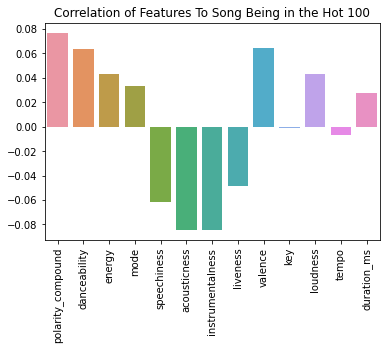

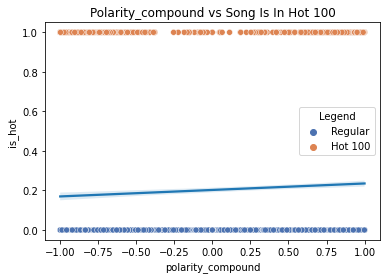

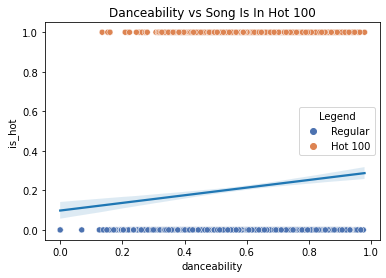

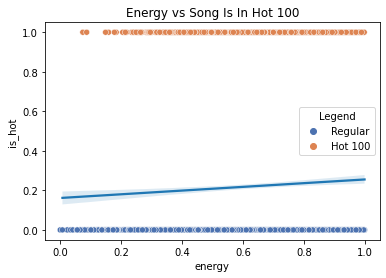

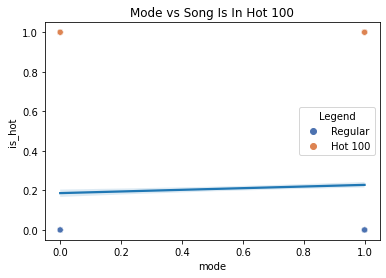

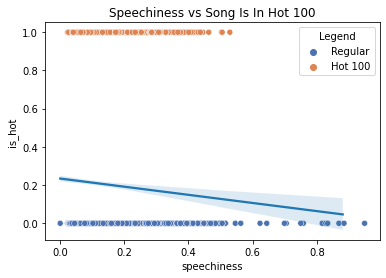

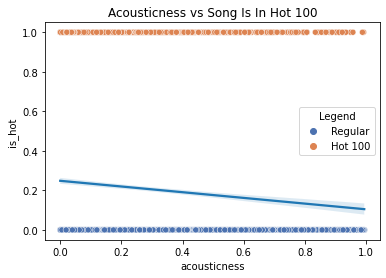

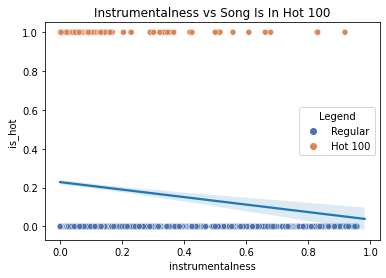

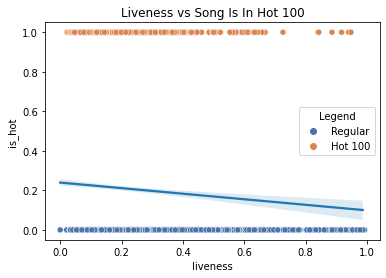

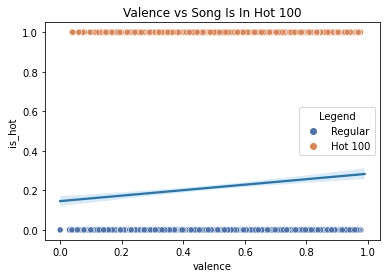

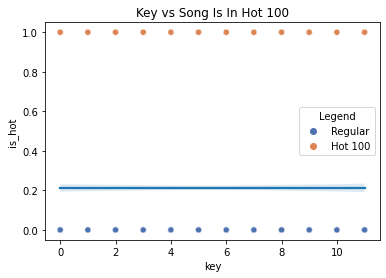

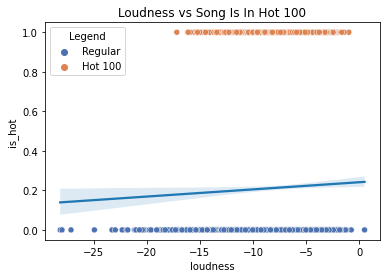

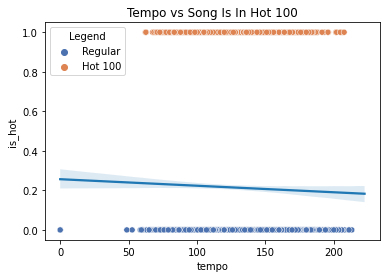

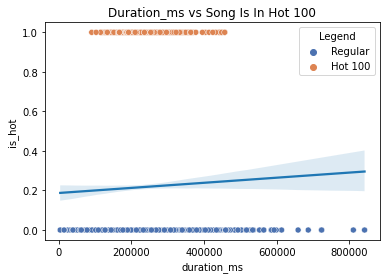

In [ ]:
import seaborn as sn
plt.figure()
corr_df = norm_df.corrwith(combined_df['is_hot'])
corr_plot = sn.barplot(x=corr_df.index, y=corr_df.values)
corr_plot.set_xticklabels(labels=corr_plot.get_xticklabels(), rotation=90);
corr_plot.set_title("Correlation of Features To Song Being in the Hot 100")
new_labels = ['Regular', 'Hot 100']


for feature in metadata:
  plt.figure()
  feature_plot = sn.scatterplot(data=combined_df.sample(5000), x=feature, y='is_hot', hue='is_hot', palette="deep")
  feature_plot_reg = sn.regplot(data=combined_df.sample(5000), x=feature, y='is_hot', scatter=False)
  feature_plot_reg.set_title(feature.capitalize() + " vs Song Is In Hot 100")
  feature_plot.legend_.set_title('Legend')
  for t, l in zip(feature_plot.legend_.texts, new_labels): 
    t.set_text(l)


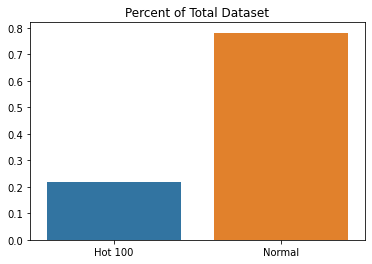

In [ ]:
song_types = ["Hot 100", "Normal"]
percent_hot = sum(combined_df['is_hot'] == 1) / len(combined_df)
percent_normal = sum(combined_df['is_hot'] == 0) / len(combined_df)
percents = [percent_hot, percent_normal]
precent_result_plot = sn.barplot(x=song_types, y= percents)
precent_result_plot.set_title("Percent of Total Dataset");

# Creating Datasets
We create datasets by extracting the useful features from the combined dataframe, since metadata such as ID are not important to our model. We split our data into three sets: train, test, and validation with 60% of the data being in the test set, and 20% in each of the others.

In [ ]:
metadata= ["polarity_compound",	"danceability",	"energy", "mode", "speechiness", "acousticness", "instrumentalness",	"liveness",	"valence", "key", "loudness", "tempo", "duration_ms", "is_hot"]
features_df = norm_df.copy(deep=True)
features_df['result'] = combined_df['is_hot']
labels = features_df['result']
features = features_df.iloc[:, :13]
X=features
y=np.ravel(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, train_size = 0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25009122977739934)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy=0.4)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
# X_rosV, y_rosV = ros.fit_resample(X_val, y_val)
# # print(len(X_test))
# # print(len(X_ros))
# # len(X_rosV)

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


# Training Models (10,000 Regular Songs)

### Multi-Layer Neural Network

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(13,)))
model.add(Dropout(0.2, input_shape=(64,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2, input_shape=(64,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
opt = keras.optimizers.SGD(learning_rate=0.007)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = model.fit(X_train, y_train,epochs=30, batch_size=8,validation_data=(X_val, y_val))
# history = model.fit(X_train, y_train,epochs=30, batch_size=8)

Epoch 1/30
771/771 [==============================] - 3s 3ms/step - loss: 0.5223 - accuracy: 0.7820 - val_loss: 0.5880 - val_accuracy: 0.7656
Epoch 2/30
771/771 [==============================] - 2s 3ms/step - loss: 0.5101 - accuracy: 0.7822 - val_loss: 0.5747 - val_accuracy: 0.7656
Epoch 3/30
771/771 [==============================] - 2s 2ms/step - loss: 0.5106 - accuracy: 0.7822 - val_loss: 0.5840 - val_accuracy: 0.7656
Epoch 4/30
771/771 [==============================] - 2s 2ms/step - loss: 0.5068 - accuracy: 0.7822 - val_loss: 0.5707 - val_accuracy: 0.7656
Epoch 5/30
771/771 [==============================] - 2s 2ms/step - loss: 0.5035 - accuracy: 0.7822 - val_loss: 0.5740 - val_accuracy: 0.7656
Epoch 6/30
771/771 [==============================] - 2s 2ms/step - loss: 0.5022 - accuracy: 0.7822 - val_loss: 0.5750 - val_accuracy: 0.7656
Epoch 7/30
771/771 [==============================] - 2s 2ms/step - loss: 0.5039 - accuracy: 0.7822 - val_loss: 0.5671 - val_accuracy: 0.7656
Epoch 

In [ ]:
y_pred = model.predict(X_test)
np.set_printoptions(threshold=np.inf)
score = model.evaluate(X_test, y_test)
print(score)


65/65 [==============================] - 0s 4ms/step - loss: 0.4784 - accuracy: 0.7977
[0.4783865809440613, 0.7976653575897217]


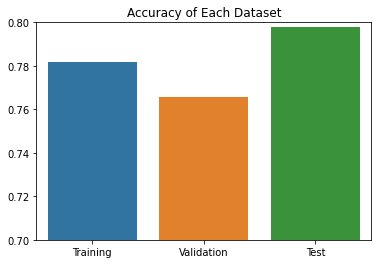

In [ ]:
labels = ["Training", "Validation", "Test"]
accuracies = [history.history['accuracy'][-1], history.history['val_accuracy'][-1], score[1]]
accuracies_plot = sn.barplot(x=labels, y=accuracies)
accuracies_plot.set_ylim(.7, .8)
accuracies_plot.set_title("Accuracy of Each Dataset");

### Multi-Layer Neural Network Half-Input Weights

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(13,)))
model.add(Dropout(0.2, input_shape=(32,)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2, input_shape=(64,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
opt = keras.optimizers.SGD(learning_rate=0.007)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = model.fit(X_train, y_train,epochs=30, batch_size=8,validation_data=(X_val, y_val))
# history = model.fit(X_train, y_train,epochs=30, batch_size=8)

Epoch 1/30
771/771 [==============================] - 4s 3ms/step - loss: 0.5361 - accuracy: 0.7684 - val_loss: 0.5657 - val_accuracy: 0.7656
Epoch 2/30
771/771 [==============================] - 2s 2ms/step - loss: 0.5141 - accuracy: 0.7822 - val_loss: 0.5578 - val_accuracy: 0.7656
Epoch 3/30
771/771 [==============================] - 2s 2ms/step - loss: 0.5138 - accuracy: 0.7822 - val_loss: 0.5631 - val_accuracy: 0.7656
Epoch 4/30
771/771 [==============================] - 2s 2ms/step - loss: 0.5108 - accuracy: 0.7822 - val_loss: 0.5562 - val_accuracy: 0.7656
Epoch 5/30
771/771 [==============================] - 2s 2ms/step - loss: 0.5143 - accuracy: 0.7822 - val_loss: 0.5599 - val_accuracy: 0.7656
Epoch 6/30
771/771 [==============================] - 2s 2ms/step - loss: 0.5093 - accuracy: 0.7822 - val_loss: 0.5570 - val_accuracy: 0.7656
Epoch 7/30
771/771 [==============================] - 2s 2ms/step - loss: 0.5096 - accuracy: 0.7822 - val_loss: 0.5585 - val_accuracy: 0.7656
Epoch 

In [ ]:
y_pred = model.predict(X_test)
np.set_printoptions(threshold=np.inf)
score = model.evaluate(X_test, y_test)
print(score)


65/65 [==============================] - 0s 2ms/step - loss: 0.4794 - accuracy: 0.7986
[0.4794101119041443, 0.798638105392456]


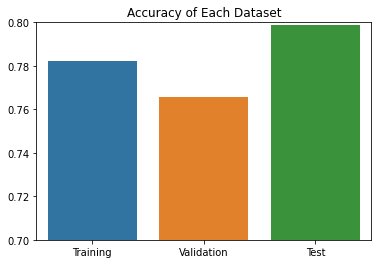

In [ ]:
labels = ["Training", "Validation", "Test"]
accuracies = [history.history['accuracy'][-1], history.history['val_accuracy'][-1], score[1]]
accuracies_plot = sn.barplot(x=labels, y=accuracies)
accuracies_plot.set_ylim(.7, .8)
accuracies_plot.set_title("Accuracy of Each Dataset");

### Single-Layer Neural Network

In [ ]:
model_linear = Sequential()
model_linear.add(Dense(1, activation='relu', input_shape=(13,)))
opt = keras.optimizers.SGD(learning_rate=0.007)
model_linear.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history_linear = model_linear.fit(X_ros, y_ros,epochs=30, batch_size=8)

Epoch 1/30
1128/1128 [==============================] - 2s 2ms/step - loss: 0.7628 - accuracy: 0.6856
Epoch 2/30
1128/1128 [==============================] - 2s 1ms/step - loss: 0.5873 - accuracy: 0.7121
Epoch 3/30
1128/1128 [==============================] - 2s 1ms/step - loss: 0.7494 - accuracy: 0.6865
Epoch 4/30
1128/1128 [==============================] - 2s 1ms/step - loss: 0.5845 - accuracy: 0.7127
Epoch 5/30
1128/1128 [==============================] - 2s 2ms/step - loss: 0.5822 - accuracy: 0.7139
Epoch 6/30
1128/1128 [==============================] - 2s 2ms/step - loss: 0.5833 - accuracy: 0.7144
Epoch 7/30
1128/1128 [==============================] - 2s 2ms/step - loss: 0.5857 - accuracy: 0.7130
Epoch 8/30
1128/1128 [==============================] - 2s 1ms/step - loss: 0.5879 - accuracy: 0.7141
Epoch 9/30
1128/1128 [==============================] - 2s 1ms/step - loss: 0.5848 - accuracy: 0.7136
Epoch 10/30
1128/1128 [==============================] - 2s 2ms/step - loss: 0.581

In [ ]:
y_pred_linear = model_linear.predict(X_test)
np.set_printoptions(threshold=np.inf)
score_linear = model_linear.evaluate(X_test, y_test)
print(score_linear)


65/65 [==============================] - 0s 2ms/step - loss: 2.4532 - accuracy: 0.7986
[2.453187942504883, 0.798638105392456]


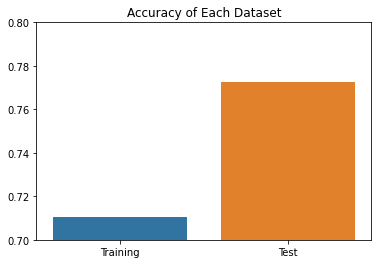

In [ ]:
labels = ["Training", "Test"]
accuracies_linear = [history_linear.history['accuracy'][-1], score[1]]
accuracies_plot_linear = sn.barplot(x=labels, y=accuracies_linear)
accuracies_plot_linear.set_ylim(.7, .8)
accuracies_plot_linear.set_title("Accuracy of Each Dataset");

### Random Forest Classification

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler().fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=9)


In [ ]:
x_train_pca = pca.fit_transform(X_train)
x_test_pca = pca.transform(X_test)

new_rf = RandomForestClassifier(n_estimators=30, max_depth=30)
new_rf.fit(x_train_pca, y_train)

RandomForestClassifier(max_depth=30, n_estimators=30)

In [ ]:
prediction_rf = new_rf.predict(x_test_pca)
test_accuracy = accuracy_score(prediction_rf, y_test)
print(test_accuracy)

0.8015564202334631


### Logistic Regression

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [ ]:

clf = LogisticRegression(max_iter=10000)
clf.fit(X_ros,y_ros)
prediction_lr = clf.predict(X_test)
accuracy = accuracy_score(prediction_lr,y_test)

In [ ]:
accuracy

0.5379377431906615

# Evaluation and Analysis
We evaluate our models by comparing the accuracies of each set. For the neural networks, the sets had similar accuracies, at around 80%. We also measured the accuracy for a variety of different models, such as a Logistic Regression Model and a Random Decision Tree Model. All of these models produced worse accuracies compared to our original model. Since each set performed fairly equally and no set had a significant increase in accuracy compared to the others, we conclude that our neural network performs well.

# Conclusion
At this point, we decided that our neural network model performed the best given the other machine learning models at predicting whether a song was in the Hot 100 list or not. Though our model was able to do well with the given features, we recognize that there are also many other factors that determine a song’s placing in the Hot 100. Such factors may include trending artists, amount of marketing, or similarity to trends in the music industry. Perhaps with these features in mind, future models can produce predictions with higher accuracy rates!